In [2]:
from util import info
import numpy as np
import os
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.animation as animation
plt.style.use(['dark_background'])

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
xn = np.linspace(-.25,1.0,200)
xnn = xn[7:-10]

data = np.load(r"C:\Users\zfj\data\081122B\func\spots_smooth.npy")
data = np.moveaxis(data[:,:,7:-10],0,1)
# fdata = data.reshape(data.shape[0],-1)

labels = np.load(r"C:\Users\zfj\data\081122B\func\spots_labels.npy")
ue = np.array([
[-24.74181249, -24.74181249, -16.49454166, -16.49454166, -16.49454166,
   -8.24727083,  -8.24727083,   0.,           0.,           0.,
    8.24727083,   8.24727083,  16.49454166,  16.49454166,  16.49454166,
   24.74181249,  24.74181249],
[-14.2846921,   14.2846921,  -28.56938421,   0.,          28.56938421,
  -14.2846921,   14.2846921,  -28.56938421,   0.,          28.56938421,
  -14.2846921,   14.2846921,  -28.56938421,   0.,          28.56938421,
  -14.2846921,   14.2846921 ]]).T

# cv = KFold(5, shuffle=True, random_state=seed)

In [104]:
xnn[32]

-0.0050251256281406975

In [235]:
# class PositionalEmbedding(layers.Layer):
#     def __init__(self, ndims):
#         super().__init__()
#         # self.ndims = ndims
#         # self.input = layers.Input((None,ndims))
#         self.norm = layers.Normalization(axis = -1)

#     def call(self, x):
#         x = self.norm(x)

class BaseAttention(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = layers.MultiHeadAttention(**kwargs)
        self.layernorm = layers.LayerNormalization()
        self.add = layers.Add()
    
class CrossAttention(BaseAttention):
    def call(self, x,  context):
        attn_output, attn_scores = self.mha(
            query = x,
            key = context,
            value = context,
            return_attention_scores = True,
            use_causal_mask = True,
        )

        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query = x,
            value = x,
            key = x
        )

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query = x,
            value = x,
            key = x,
            use_causal_mask	= True
        )

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x
    
class FeedForward(layers.Layer):
    def __init__(self, ndims_internal, ndims_out, dropout_rate = .1):
        super().__init__()
        self.seq = keras.Sequential([
            layers.Dense(ndims_internal, activation='relu'),
            layers.Dense(ndims_out),
            layers.Dropout(dropout_rate),
        ])
        self.add = layers.Add()
        self.layernorm = layers.LayerNormalization()

    def call(self, x):

        y = self.seq(x)
        # print('seq', y.shape)
        x = self.add([x, y])
        # print('add', x.shape)
        x = self.layernorm(x)
        # print('norm', x.shape)
        return x

class EncoderLayer(layers.Layer):
    def __init__(self, *, ndims, num_heads, ndims_dff, dropout_rate = .1):
        super().__init__()

        self.self_attention = CausalSelfAttention(
            num_heads = num_heads,
            key_dim = ndims,
            dropout = dropout_rate
        )

        self.ffn = FeedForward(ndims_dff, ndims, dropout_rate = dropout_rate) # why not dropout?

    def call(self, x):
        x = self.self_attention(x)
        # print('self_attention', x.shape)
        x = self.ffn(x)
        # print('ffn', x.shape)
        return x

class Encoder(layers.Layer):
    def __init__(self, *, num_layers, ndims, num_heads, ndims_dff, dropout_rate=.1):
        super().__init__()
        
        self.dff = layers.Dense(ndims)
        self.dropout = layers.Dropout(dropout_rate)


        self.enc_layers = [EncoderLayer(
            ndims=ndims, 
            num_heads=num_heads, 
            ndims_dff=ndims_dff, 
            dropout_rate=dropout_rate
            ) for _ in range(num_layers)]

        # self.dropout = layers.Dropout(dropout_rate)
    
    def call(self, x):
        # print('input', x.shape)
        x = self.dff(x)
        # print('embedding', x.shape)
        x = self.dropout(x)
        # print('dropout', x.shape)

        for layer in self.enc_layers:
            x = layer(x)
        return x

class DecoderLayer(layers.Layer):
    def __init__(self, *, ndims, num_heads, ndims_dff, dropout_rate=.1):
        super(DecoderLayer, self).__init__()
        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=ndims,
            dropout=dropout_rate,
        )
        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=ndims,
            dropout=dropout_rate
        )
        self.ffn = FeedForward(ndims_dff, ndims)
    
    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)

        self.last_attn_scores = self.cross_attention.last_attn_scores
        x = self.ffn(x)
        return x

class Decoder(layers.Layer):
    def __init__(self, *, num_layers, ndims, num_heads, ndims_dff, dropout_rate=.1):
        super(Decoder, self).__init__()

        self.dff = layers.Dense(ndims)
        self.dropout = layers.Dropout(dropout_rate)

        self.dec_layers = [DecoderLayer(
            ndims=ndims,
            num_heads=num_heads,
            ndims_dff=ndims_dff,
            dropout_rate=dropout_rate
        ) for _ in range(num_layers)]

        self.last_attn_scores = None
    
    def call(self, x, context):

        x = self.dff(x)
        x = self.dropout(x)

        for layer in self.dec_layers:
            x = layer(x, context)
        
        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        return x

class Transformer(keras.Model):
    def __init__(self, * ,num_layers, ndims, num_heads, ndims_dff, dropout_rate = 0.1):
        super().__init__()

        self.encoder = Encoder(
            num_layers=num_layers, 
            ndims=ndims,
            num_heads=num_heads, 
            ndims_dff=ndims_dff,
            dropout_rate=dropout_rate
        )

        self.decoder = Decoder(
            num_layers=num_layers, 
            ndims=ndims,
            num_heads=num_heads, 
            ndims_dff=ndims_dff,
            dropout_rate=dropout_rate
        )

        self.final_layer = layers.Dense(2)

        self.attention = None
    
    def call(self, inputs):
        context, x = inputs
        
        context = self.encoder(context)
        x = self.decoder(x, context)

        x = self.final_layer(x)

        self.attention = self.decoder.last_attn_scores
        # try:
        #     del logits._keras_mask
        # except AttributeError:
        #     pass
            
        # return logits
        return x

    

In [236]:
#let's jsut see how the transformer architecture does on the original problem
mod = Transformer(num_layers = 4, ndims = 64, ndims_dff = 128, num_heads = 5, dropout_rate=0.1)
print(data.shape)
output = mod((np.moveaxis(data,-1,-2), np.zeros((1222,183,2))))
mod.summary()


(1222, 170, 183)
Model: "transformer_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_8 (Encoder)         multiple                  410048    
                                                                 
 decoder_8 (Decoder)         multiple                  731584    
                                                                 
 dense_170 (Dense)           multiple                  130       
                                                                 
Total params: 1,141,762
Trainable params: 1,141,762
Non-trainable params: 0
_________________________________________________________________


In [29]:
print(data.shape, output.shape)

(1222, 170, 183) (1222, 183, 2)


In [237]:
class CustomSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, ndims, warmup_steps=4000):
        super().__init__()
        self.ndims = tf.cast(ndims, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.ndims) * tf.math.minimum(arg1, arg2)

mask = xnn>0

# def mse_loss(*args, **kwargs):
    
def mse_loss(y_true, y_pred):

    # loss = tf.keras.losses.MeanSquaredError(reduction='none')
    
    # mse = loss(*args, **kwargs)
    # print(mse.shape)
    
    # mse *= tf.cast(mask, dtype=mse.dtype)

    
    # print(mse.shape)

    # mse = tf.reduce_sum(mse)

    # print(mse.shape)
    # print(y_true.shape, type(y_true), y_true.dtype)
    # print(y_true[0,32:35,:].numpy())


    ae = (y_true - y_pred) * tf.cast(mask[None,:,None], dtype=y_true.dtype)
    se = tf.math.reduce_sum(tf.square(ae), axis=-1)
    mse = tf.math.reduce_mean(se)#, axis=(0,1))
    
    return mse

In [238]:
mod.compile(
    loss = mse_loss,
    optimizer = keras.optimizers.Adam(CustomSchedule(64), beta_1 = 0.9, beta_2 = 0.98, epsilon = 1e-9)
)

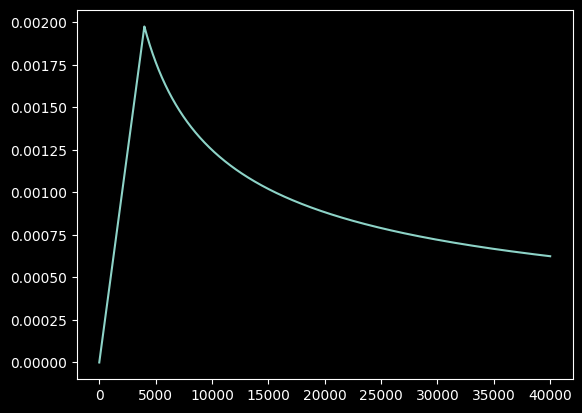

In [325]:
plt.plot(CustomSchedule(64)(tf.range(40000, dtype=tf.float32)))

In [117]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(np.moveaxis(data,-1,-2), ue[labels,None,:], test_size = .2)
print([_.shape for _ in (xtrain, xtest, ytrain, ytest)])

[(977, 183, 170), (245, 183, 170), (977, 1, 2), (245, 1, 2)]


In [239]:
# ytrain_t = np.tile(ytrain, (1, 183, 1))
# print(ytrain_t.shape)
ytrain_t = np.zeros((ytrain.shape[0], 183, 2))
# ytrain_t[:,33:,:] = ytrain

ytest_t = np.zeros((ytest.shape[0], 183, 2))
# ytest_t[:,33:,:] = ytest

# mod.fit((xtrain, ytrain_t), ytrain_t, epochs = 20, validation_data = ()))


history = mod.fit((xtrain, ytrain_t), ytrain, epochs = 50, validation_data = ((xtest, ytest_t), ytest))

Epoch 1/50
31/31 [==============================] - 75s 2s/step - loss: 522.1856 - val_loss: 522.3925
Epoch 2/50
31/31 [==============================] - 64s 2s/step - loss: 500.5221 - val_loss: 493.1207
Epoch 3/50
31/31 [==============================] - 66s 2s/step - loss: 458.7249 - val_loss: 449.0161
Epoch 4/50
31/31 [==============================] - 68s 2s/step - loss: 407.6199 - val_loss: 416.5001
Epoch 5/50
31/31 [==============================] - 66s 2s/step - loss: 368.7646 - val_loss: 374.7651
Epoch 6/50
31/31 [==============================] - 63s 2s/step - loss: 338.2235 - val_loss: 350.0470
Epoch 7/50
31/31 [==============================] - 63s 2s/step - loss: 312.4552 - val_loss: 334.4924
Epoch 8/50
31/31 [==============================] - 63s 2s/step - loss: 296.7151 - val_loss: 316.8561
Epoch 9/50
31/31 [==============================] - 64s 2s/step - loss: 276.3406 - val_loss: 302.7557
Epoch 10/50
31/31 [==============================] - 65s 2s/step - loss: 261.6241 

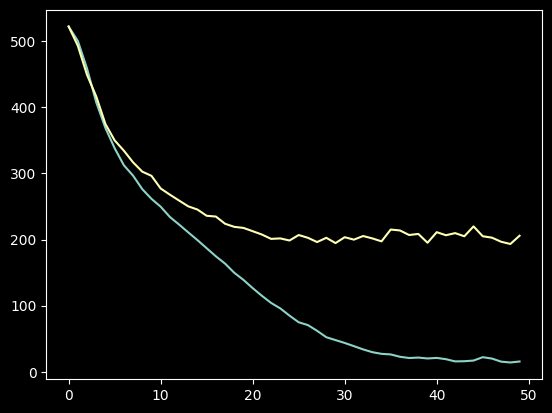

In [241]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])


In [212]:
xtest.shape

(245, 183, 170)

In [280]:
# print(ytest.shape)
yhat = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
yhat.write(0, np.zeros((245,2)))
yhat.stack()
for t in range(183):
    y = tf.transpose(yhat.stack(), (1,0,2))
    
    # y = yhat.stack()

    # pred = mod.predict((xtest[:,:(t+1),:], y))
    
    pred = mod((xtest[:,:(t+1),:], y), training=False)

    yhat.write(t+1, pred[:,-1, :])

# yhat = mod.predict((xtest, ytest))
# yhat.shape

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "c:\Users\zfj\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,  File "c:\Users\zfj\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):  File "c:\Users\zfj\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)  File "C:\Users\zfj\AppData\Local\Temp\ipykernel_21888\1445834117.py", line 3, in <module>
    yhat.write(0, np.zeros((245,2)))  File "c:\Users\zfj\anaconda3\envs\tf\lib\site-packages\tensorflow\python\util\tf_should_use.py", line 24

In [306]:
# yhat2 = mod.predict((xtest, np.zeros((245,183,2))))

# yhat3 = mod.predict((xtest, yhat2))

yhat10 = yhat3
for _ in range(9):
    yhat10 = mod.predict((xtest, yhat10))



8/8 [==============================] - 10s 1s/step


(245, 183, 2) (245, 184, 2) (245, 1, 2) (245, 183)


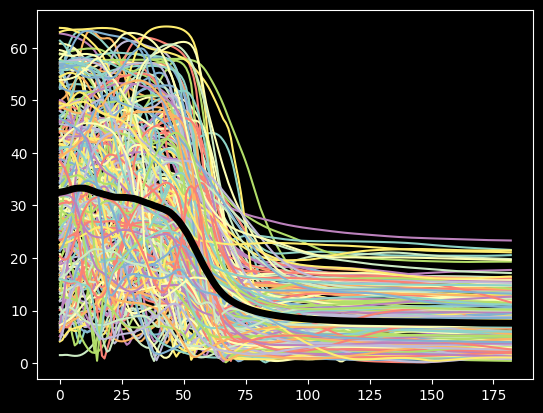

In [307]:

# mse = np.sqrt(((yhat2 - ytest)**2).sum(axis=2))
mse = np.sqrt(((yhat10 - ytest)**2).sum(axis=2))
# mse = np.sqrt(((np.moveaxis(yhat.stack().numpy(),0,1) - ytest)**2).sum(axis=2))
print(yhat2.shape, np.moveaxis(yhat.stack().numpy(),0,1).shape, ytest.shape, mse.shape)

plt.plot(mse.T)
plt.plot(mse.mean(axis=0), color='k', linewidth=5)

plt.show()

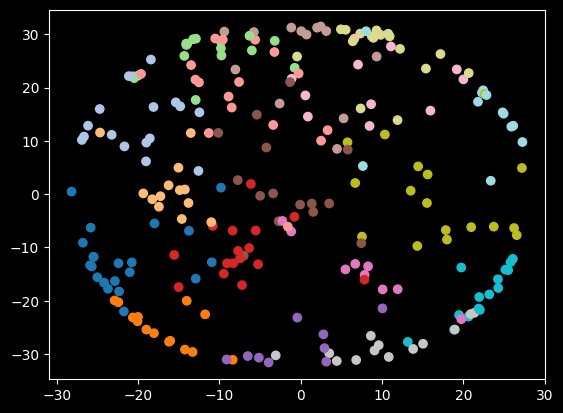

In [308]:
# yhat.stack().numpy()[-1,:,:].shape
_,yi = np.unique(ytest, axis=0, return_inverse=True)
# plt.scatter(*yhat.stack().numpy()[-1,:,:].T, c=yi, cmap='tab20')
# plt.scatter(*yhat2[:,-1,:].T, c=yi, cmap='tab20')
plt.scatter(*yhat10[:,-1,:].T, c=yi, cmap='tab20')

In [309]:
# yhat.stack().numpy().shape
inf = info.MI(yi, ndims=2)
# MI_t = np.asarray([inf.QE(yhat.stack().numpy()[t], nreps=50, nsamps=5) for t in range(183)])
# MI_t2 = np.asarray([inf.QE(yhat2[:,t], nreps=50, nsamps=5) for t in range(183)])
MI_t10 = np.asarray([inf.QE(yhat10[:,t], nreps=50, nsamps=5) for t in range(183)])


c:\Users\zfj\code\functionalimaginganalysis\python\util\info.py:38: RuntimeWarning: divide by zero encountered in log2
  HR = -np.nansum(self.Py * np.log2(self.Py))
c:\Users\zfj\code\functionalimaginganalysis\python\util\info.py:38: RuntimeWarning: invalid value encountered in multiply
  HR = -np.nansum(self.Py * np.log2(self.Py))
c:\Users\zfj\code\functionalimaginganalysis\python\util\info.py:39: RuntimeWarning: divide by zero encountered in log2
  HRS = -np.nansum(self.Py_x * np.log2(self.Py_x) * self.stim_prob)
c:\Users\zfj\code\functionalimaginganalysis\python\util\info.py:39: RuntimeWarning: invalid value encountered in multiply
  HRS = -np.nansum(self.Py_x * np.log2(self.Py_x) * self.stim_prob)
c:\Users\zfj\code\functionalimaginganalysis\python\util\info.py:55: RuntimeWarning: divide by zero encountered in log2
  HRS_ind = -np.nansum(Py_x_ind * np.log2(Py_x_ind) * self.stim_prob)
c:\Users\zfj\code\functionalimaginganalysis\python\util\info.py:55: RuntimeWarning: invalid value enc

2.3043821227411705 0.5637683355761759


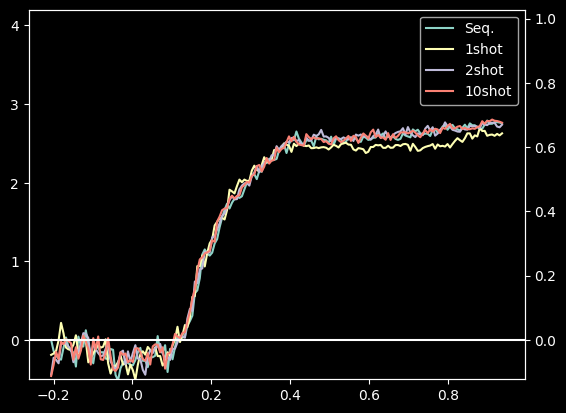

In [310]:
plt.plot(xnn,MI_t)
plt.plot(xnn,MI_t2)
plt.plot(xnn,MI_t3)
plt.plot(xnn,MI_t10)


plt.legend(['Seq.', '1shot', '2shot', '10shot'])

plt.axhline(0,0,1,color='w')

plt.ylim(-.5, 4.2)
y = plt.ylim()
plt.twinx()
plt.ylim(y / np.log2(17))
print(np.median(MI_t), np.median(MI_t)/np.log2(17))
# plt.plot(MI_t[:5])


# plt.xlim(.05,.25)

In [287]:
class Inference(tf.Module):
    def __init__(self, mod):
        self.mod = mod

    def __call__(self, x):
        y = self.mod.predict((x, np.zeros((245,183,2))))
        
        self.mod([x, y[:,:-1]], training=False)
        w = self.mod.decoder.last_attn_scores
        return y,w


infr = Inference(mod)
yhat2,w = infr(xtest)

8/8 [==============================] - 9s 1s/step


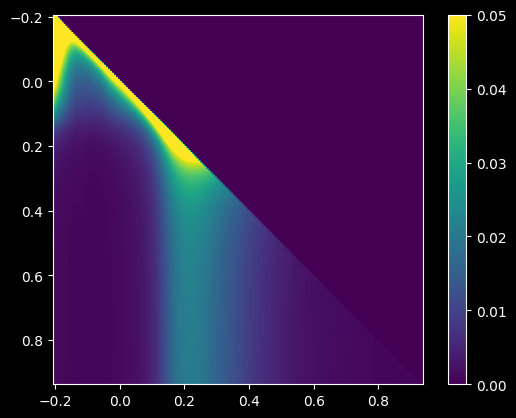

In [292]:
plt.imshow(w.numpy().mean(axis=0)[0], extent = [xnn[0],xnn[-1],xnn[-1], xnn[0]])
plt.colorbar()
plt.clim(0,.05)

In [39]:
history2 = mod.fit((xtrain, ytrain), ytrain, epochs = 30, validation_data = ((xtest, ytest), ytest))

Epoch 1/30
31/31 [==============================] - 26s 832ms/step - loss: 51.1096 - val_loss: 45.3804
Epoch 2/30
31/31 [==============================] - 26s 834ms/step - loss: 46.2095 - val_loss: 40.7323
Epoch 3/30
31/31 [==============================] - 31s 1s/step - loss: 41.1131 - val_loss: 36.5888
Epoch 4/30
31/31 [==============================] - 29s 941ms/step - loss: 36.4537 - val_loss: 32.0430
Epoch 5/30
31/31 [==============================] - 26s 853ms/step - loss: 32.1252 - val_loss: 28.7948
Epoch 6/30
31/31 [==============================] - 34s 1s/step - loss: 27.7824 - val_loss: 24.7705
Epoch 7/30
31/31 [==============================] - 35s 1s/step - loss: 23.2532 - val_loss: 20.6373
Epoch 8/30
31/31 [==============================] - 35s 1s/step - loss: 18.9525 - val_loss: 17.7484
Epoch 9/30
31/31 [==============================] - 34s 1s/step - loss: 15.9418 - val_loss: 15.8531
Epoch 10/30
31/31 [==============================] - 34s 1s/step - loss: 13.4981 - val_l

In [42]:
history2 = mod.fit((xtrain, ytrain), ytrain, epochs = 30, validation_data = ((xtest, ytest), ytest))

Epoch 1/30
31/31 [==============================] - 26s 833ms/step - loss: 2.0610 - val_loss: 11.5696
Epoch 2/30
31/31 [==============================] - 26s 857ms/step - loss: 1.9719 - val_loss: 9.0690
Epoch 3/30
31/31 [==============================] - 26s 839ms/step - loss: 1.6494 - val_loss: 10.8407
Epoch 4/30
31/31 [==============================] - 26s 828ms/step - loss: 1.5692 - val_loss: 11.2411
Epoch 5/30
31/31 [==============================] - 25s 822ms/step - loss: 3.1732 - val_loss: 14.6711
Epoch 6/30
31/31 [==============================] - 25s 824ms/step - loss: 5.2769 - val_loss: 13.4603
Epoch 7/30
31/31 [==============================] - 27s 874ms/step - loss: 3.0733 - val_loss: 15.2488
Epoch 8/30
31/31 [==============================] - 27s 888ms/step - loss: 2.8143 - val_loss: 8.8390
Epoch 9/30
31/31 [==============================] - 27s 881ms/step - loss: 3.4331 - val_loss: 9.7831
Epoch 10/30
31/31 [==============================] - 27s 873ms/step - loss: 1.7502 - 

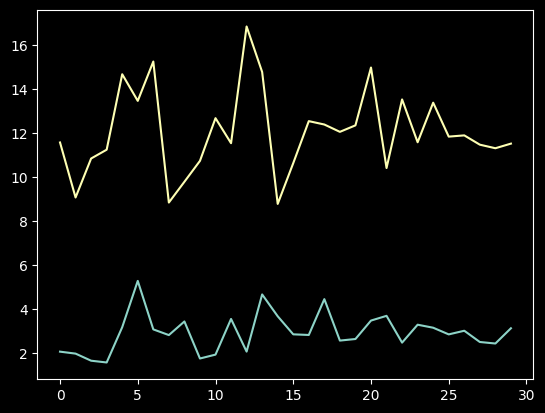

In [45]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])


In [322]:
print(np.diff(np.unique(ue[:,1])))
print(np.unique(ue[:,1]))

[14.28469211 14.2846921  14.2846921  14.28469211]
[-28.56938421 -14.2846921    0.          14.2846921   28.56938421]


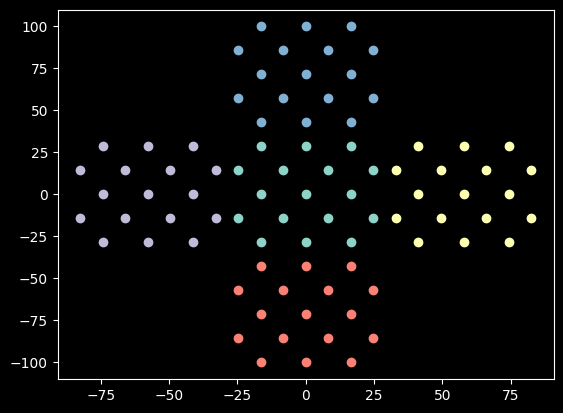

In [324]:
plt.scatter(ue[:,0],ue[:,1])
plt.scatter(ue[:,0] + (24.74181249*2 + 8.24727083),ue[:,1])
plt.scatter(ue[:,0] - (24.74181249*2 + 8.24727083),ue[:,1])
plt.scatter(ue[:,0] ,ue[:,1] - (28.56938421*2 + 14.28469211))
plt.scatter(ue[:,0] ,ue[:,1] + (28.56938421*2 + 14.28469211))
